<a href="https://colab.research.google.com/github/ISE-CS4445-AI/challenge-6-justyna-przy/blob/main/challenge-6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge #6: Reducing Overfitting with Regularization (FashionMNIST)

**Instructions**:
- This challenge builds on **Week 6**’s regularization lessons: **data augmentation**, **dropout**, and **weight decay**.
- We demonstrate a baseline CNN on **FashionMNIST** that clearly overfits. Then we apply these techniques to see the improvement.

**Scoring**:  9 points total. Fill in the `# TODO` placeholders and fill in the final reflection markdown cell. **There is no autograder** for this assignment. If your code works without errors and achieves the objectives of reducing overfitting by the end of this challenge, you will have done well. 👍

We’ll use the **FashionMNIST** dataset, which consists of 60,000 training images and 10,000 test images of 28x28 grayscale images of 10 different fashion categories. By applying these techniques, we aim to reduce overfitting and improve robust performance.

---

## Imports & Setup

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

print("Torch version:", torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)

from torch.utils.data import DataLoader

Torch version: 2.5.1+cu124
Using device: cuda


### Utility functions

Defining the utility function to plot metrics below.

In [8]:
'''
Description:
Utility function to plot line plots in a single graph

Params:
dataDict: List - A list of tuples containing the data to be plotted and corresponding plot params as a dictionary (optional).
           Expected key names in paramDict:
           -> label: str - String label to be given to the plot.
                           Only necessary if the 'legend' function param is set to True (False by default).
           -> ha: str - Specifies the horizontal alignment ('left', 'right' or 'center') of text above each point in the plot.
           -> fontsize: int - Sets the font size of text displayed above each point in the plot.
           -> marker: str - Sets the style of marker to be displayed for each data point on the plot. Set to 'o' by default.
           -> decimalPlaces: int - Sets the number of decimal places to display for each data point.
           -> displayPercent: bool - Boolean to decide whether to display numbers in percentage format.
           -> displayOffset: float - positive or negative float value that determines the display offset of text above data point.
title: str - [optional] Title to be set for the graph.
xlabel: str - [optional] Label for the x-axis to be set for the graph.
ylabel: str - [optional] Label for the y-axis to be set for the graph.
figSize: Tuple - [optional] Sets a custom figure size for the plot based on the width and height values passed as a tuple pair.
legend: bool - [optional] Boolean to decide whether to show the legend or not. Set to False by default
'''
def plotMetrics(dataList, X, title='', xlabel='', ylabel='', figSize=None, legend=False):
    if figSize:
            plt.figure(figsize=(figSize))
    for data in dataList:
        y, paramDict = data
        # Getting plot params
        label = paramDict['label'] if 'label' in paramDict else ''
        marker = paramDict['marker'] if 'marker' in paramDict else 'o'
        ha = paramDict['ha'] if 'ha' in paramDict else 'center'
        fontSize = paramDict['fontSize'] if 'fontSize' in paramDict else 8
        decimalPlaces = paramDict['decimalPlaces'] if 'decimalPlaces' in paramDict else 2
        displayPercent = paramDict['displayPercent'] if 'displayPercent' in paramDict else False
        displayOffset = paramDict['displayOffset'] if 'displayOffset' in paramDict else 0.005

        plt.plot(X, y, label=label, marker=marker)

        # Getting the data values to show on the plotted points along the line
        for i, v in enumerate(y):
            percentMultiplier = 100 if displayPercent else 1
            v_str = f'{v * percentMultiplier:.{decimalPlaces}f}{"%" if displayPercent else ""}'
            plt.text(i + 1, v + displayOffset, v_str, ha=ha, fontsize=fontSize)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if legend:
        plt.legend()
    plt.show()

## Task 1: getTransforms(augmentation=False) <font color='green'>(1 point)</font>

**Goal**: Return a **train_transform** and a **test_transform**.  
- If `augmentation=True`, apply random transformations. Otherwise just basic.  
- *FashionMNIST* is 28×28 grayscale, so consider **random horizontal flip** or **random rotation**. Keep it simple.

In [9]:
def getTransforms(augmentation=False):
    # mean,std for FashionMNIST (approx)
    mean = (0.2860,)
    std = (0.3530,)

    # Define test transform (no augmentation, just normalization)
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    if augmentation:
        # Define train transform with augmentations
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        return train_transform, test_transform

    return test_transform, test_transform

## Task 2: create the dataloaders <font color='green'>(1 point)</font>

In [10]:
def load_fashionMNIST_data(batch_size=64, augmentation=False):
    """
    return train_loader, test_loader
    """

    train_transform, test_transform = getTransforms(augmentation)

    train_dataset = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=train_transform, download=True
    )
    test_dataset = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=test_transform, download=True
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = load_fashionMNIST_data(batch_size=64)
print("Train set size:", len(train_loader.dataset))
print("Test set size:", len(test_loader.dataset))

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.2MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.2MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Train set size: 60000
Test set size: 10000


## Task 3: Define a CNN with Dropout  <font color='green'>(2 points)</font>

**Task**:  
- Build a small **CNN** with a few convolution layers, each followed by ReLU & maxpool.  
- Insert **dropout** layers (e.g., `nn.Dropout(0.3)`) to help reduce overfitting.  
- The final linear outputs 10 classes.  
- We'll call it `NetFashion`.

In [15]:
class NetFashion(nn.Module):
    def __init__(self, dropout_prob=0.3, useRegularization=False):
        super().__init__()
        self.useRegularization = useRegularization
        # TODO: Build a sample CNN architecture (refer architecture from week 6 exercise notebook if needed)
        # Note that the FashionMNIST dataset has 10 classes, input size of 28x28 and 1 channel (greyscale)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.pool  = nn.MaxPool2d(2,2) # Remember that a kernel size and stride of 2 each effectively halves the size of the image!

        self.fc1 = nn.Linear(in_features=128 * 7 * 7, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=10)

        if self.useRegularization:
          self.dropout = nn.Dropout(p=dropout_prob)
        else:
          self.dropout = nn.Identity()


    def forward(self, x):
        # shape x: (batch,3,32,32)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # (batch,64,16,16)

        # Use regularisation layers as you see fit

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.dropout(F.relu(self.fc1(x)))  # apply before fc

        out = self.fc2(x)
        return out

## Training Loop

Below is a standard training loop with helper train and test methods defined which should look familiar by now. :)

In [16]:
def train(dataloader, model, loss_fn, optimiser):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        optimiser.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()
        optimiser.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimiser, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in tqdm(range(epochs), desc="Epochs"):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimiser)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy

## Task 4: Evaluate & Check Test Accuracy

**Task**:  
1. Measure train and test metrics for non-regularised model with non-augmented data.  
2. Do the same train and test loop for your regularised model on augmented data with weight decay in the optimiser and observe the difference.
   1. However, apply all the different techniques individually.
   2. Run the code cells to plot metrics after each experiment

### Task 4.1: Non-regularised model with non-augmented data  <font color='green'>(1 point)</font>

In [17]:
model = NetFashion().to(device) # Getting the Fashion MNIST model

# TODO: Define the loss function and the optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [18]:
epochs = 10
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.303831  [   64/60000]
loss: 0.472589  [ 6464/60000]
loss: 0.320705  [12864/60000]
loss: 0.534879  [19264/60000]
loss: 0.520654  [25664/60000]
loss: 0.310693  [32064/60000]
loss: 0.203377  [38464/60000]
loss: 0.331220  [44864/60000]
loss: 0.254638  [51264/60000]
loss: 0.219590  [57664/60000]


Epochs:  10%|█         | 1/10 [00:30<04:34, 30.47s/it]

Train Error: 
 Accuracy: 90.0%, Avg loss: 0.267196 

Test Error: 
 Accuracy: 88.5%, Avg loss: 0.301904 

Epoch 2:

loss: 0.283904  [   64/60000]
loss: 0.278438  [ 6464/60000]
loss: 0.177717  [12864/60000]
loss: 0.238650  [19264/60000]
loss: 0.178032  [25664/60000]
loss: 0.203823  [32064/60000]
loss: 0.238893  [38464/60000]
loss: 0.062269  [44864/60000]
loss: 0.272754  [51264/60000]
loss: 0.179045  [57664/60000]


Epochs:  20%|██        | 2/10 [01:01<04:06, 30.86s/it]

Train Error: 
 Accuracy: 93.2%, Avg loss: 0.186629 

Test Error: 
 Accuracy: 91.4%, Avg loss: 0.246637 

Epoch 3:

loss: 0.233968  [   64/60000]
loss: 0.185663  [ 6464/60000]
loss: 0.068612  [12864/60000]
loss: 0.143376  [19264/60000]
loss: 0.267927  [25664/60000]
loss: 0.169222  [32064/60000]
loss: 0.119227  [38464/60000]
loss: 0.271725  [44864/60000]
loss: 0.084511  [51264/60000]
loss: 0.286388  [57664/60000]


Epochs:  30%|███       | 3/10 [01:31<03:33, 30.53s/it]

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.140697 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.218994 

Epoch 4:

loss: 0.103199  [   64/60000]
loss: 0.142423  [ 6464/60000]
loss: 0.082634  [12864/60000]
loss: 0.121561  [19264/60000]
loss: 0.174014  [25664/60000]
loss: 0.026291  [32064/60000]
loss: 0.017374  [38464/60000]
loss: 0.245050  [44864/60000]
loss: 0.219552  [51264/60000]
loss: 0.122166  [57664/60000]


Epochs:  40%|████      | 4/10 [02:07<03:15, 32.63s/it]

Train Error: 
 Accuracy: 96.2%, Avg loss: 0.103715 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.211789 

Epoch 5:

loss: 0.068710  [   64/60000]
loss: 0.052871  [ 6464/60000]
loss: 0.140064  [12864/60000]
loss: 0.099089  [19264/60000]
loss: 0.083946  [25664/60000]
loss: 0.195751  [32064/60000]
loss: 0.066890  [38464/60000]
loss: 0.074083  [44864/60000]
loss: 0.063633  [51264/60000]
loss: 0.103227  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:38<02:40, 32.19s/it]

Train Error: 
 Accuracy: 96.9%, Avg loss: 0.084048 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.233265 

Epoch 6:

loss: 0.062637  [   64/60000]
loss: 0.081674  [ 6464/60000]
loss: 0.074972  [12864/60000]
loss: 0.074319  [19264/60000]
loss: 0.059208  [25664/60000]
loss: 0.125551  [32064/60000]
loss: 0.055677  [38464/60000]
loss: 0.007866  [44864/60000]
loss: 0.155642  [51264/60000]
loss: 0.051231  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:09<02:06, 31.56s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.065119 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.241505 

Epoch 7:

loss: 0.069715  [   64/60000]
loss: 0.052631  [ 6464/60000]
loss: 0.010463  [12864/60000]
loss: 0.033796  [19264/60000]
loss: 0.047844  [25664/60000]
loss: 0.029533  [32064/60000]
loss: 0.036581  [38464/60000]
loss: 0.109984  [44864/60000]
loss: 0.044043  [51264/60000]
loss: 0.098208  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:41<01:35, 31.75s/it]

Train Error: 
 Accuracy: 97.7%, Avg loss: 0.063084 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.280556 

Epoch 8:

loss: 0.044872  [   64/60000]
loss: 0.045562  [ 6464/60000]
loss: 0.119258  [12864/60000]
loss: 0.018330  [19264/60000]
loss: 0.075973  [25664/60000]
loss: 0.032635  [32064/60000]
loss: 0.123911  [38464/60000]
loss: 0.048732  [44864/60000]
loss: 0.013740  [51264/60000]
loss: 0.116541  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:13<01:03, 31.78s/it]

Train Error: 
 Accuracy: 99.2%, Avg loss: 0.026576 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.269214 

Epoch 9:

loss: 0.013058  [   64/60000]
loss: 0.002380  [ 6464/60000]
loss: 0.072263  [12864/60000]
loss: 0.115701  [19264/60000]
loss: 0.002754  [25664/60000]
loss: 0.017065  [32064/60000]
loss: 0.025818  [38464/60000]
loss: 0.049520  [44864/60000]
loss: 0.042530  [51264/60000]
loss: 0.037747  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:46<00:32, 32.12s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.025894 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.342397 

Epoch 10:

loss: 0.013476  [   64/60000]
loss: 0.000179  [ 6464/60000]
loss: 0.001397  [12864/60000]
loss: 0.026254  [19264/60000]
loss: 0.003326  [25664/60000]
loss: 0.007894  [32064/60000]
loss: 0.017270  [38464/60000]
loss: 0.057658  [44864/60000]
loss: 0.009432  [51264/60000]
loss: 0.007614  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:16<00:00, 31.66s/it]

Train Error: 
 Accuracy: 98.9%, Avg loss: 0.032590 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.378944 

Done training!


Plotting metrics

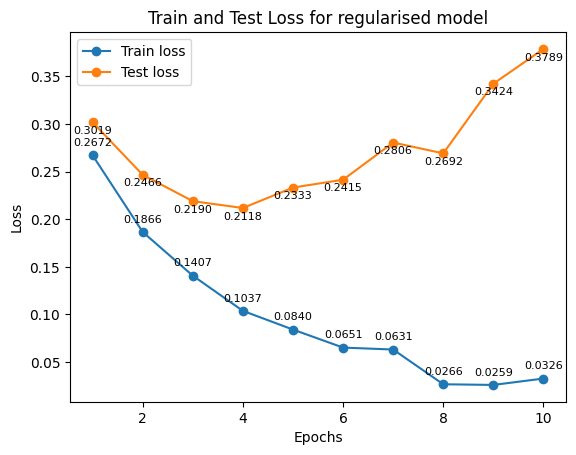

In [19]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.01}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.012})]
plotTitle = 'Train and Test Loss for regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True)

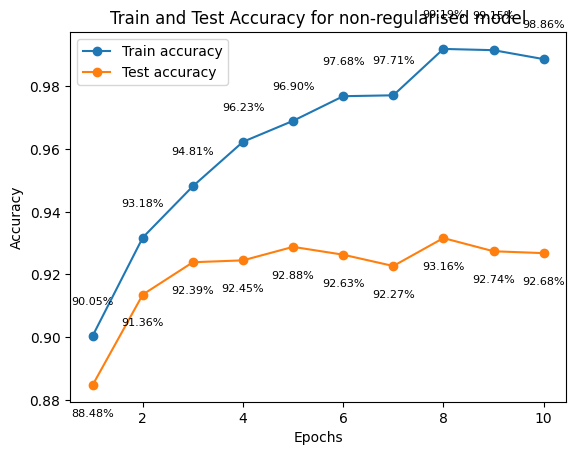

In [20]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': 0.01,
                                      'decimalPlaces': 2, 'displayPercent': True}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': -0.01,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for non-regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True)

### Task 4.2: With regularisation and data augmentation applied <font color='green'>(3 points)</font>
Train and test the same model with different regularisation techniques applied where you apply them one at a time

In [21]:
# Apply only data augmentation
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion(useRegularization=False).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.300280  [   64/60000]
loss: 0.538105  [ 6464/60000]
loss: 0.430451  [12864/60000]
loss: 0.379296  [19264/60000]
loss: 0.296751  [25664/60000]
loss: 0.427093  [32064/60000]
loss: 0.194252  [38464/60000]
loss: 0.164939  [44864/60000]
loss: 0.350175  [51264/60000]
loss: 0.320728  [57664/60000]


Epochs:  10%|█         | 1/10 [00:34<05:12, 34.72s/it]

Train Error: 
 Accuracy: 88.7%, Avg loss: 0.306413 

Test Error: 
 Accuracy: 88.4%, Avg loss: 0.313406 

Epoch 2:

loss: 0.272753  [   64/60000]
loss: 0.160776  [ 6464/60000]
loss: 0.150574  [12864/60000]
loss: 0.281570  [19264/60000]
loss: 0.317614  [25664/60000]
loss: 0.182271  [32064/60000]
loss: 0.203178  [38464/60000]
loss: 0.352525  [44864/60000]
loss: 0.167292  [51264/60000]
loss: 0.304824  [57664/60000]


Epochs:  20%|██        | 2/10 [01:09<04:37, 34.69s/it]

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.201861 

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.238149 

Epoch 3:

loss: 0.169724  [   64/60000]
loss: 0.261776  [ 6464/60000]
loss: 0.209944  [12864/60000]
loss: 0.133587  [19264/60000]
loss: 0.096185  [25664/60000]
loss: 0.154208  [32064/60000]
loss: 0.311219  [38464/60000]
loss: 0.104066  [44864/60000]
loss: 0.167270  [51264/60000]
loss: 0.115339  [57664/60000]


Epochs:  30%|███       | 3/10 [01:43<04:01, 34.57s/it]

Train Error: 
 Accuracy: 93.8%, Avg loss: 0.165534 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.223364 

Epoch 4:

loss: 0.093157  [   64/60000]
loss: 0.104080  [ 6464/60000]
loss: 0.242915  [12864/60000]
loss: 0.187218  [19264/60000]
loss: 0.172348  [25664/60000]
loss: 0.095816  [32064/60000]
loss: 0.099387  [38464/60000]
loss: 0.360480  [44864/60000]
loss: 0.142331  [51264/60000]
loss: 0.078250  [57664/60000]


Epochs:  40%|████      | 4/10 [02:18<03:27, 34.57s/it]

Train Error: 
 Accuracy: 94.9%, Avg loss: 0.139348 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.211085 

Epoch 5:

loss: 0.129408  [   64/60000]
loss: 0.068482  [ 6464/60000]
loss: 0.226114  [12864/60000]
loss: 0.145361  [19264/60000]
loss: 0.101861  [25664/60000]
loss: 0.097575  [32064/60000]
loss: 0.170790  [38464/60000]
loss: 0.075150  [44864/60000]
loss: 0.318878  [51264/60000]
loss: 0.144901  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:53<02:52, 34.60s/it]

Train Error: 
 Accuracy: 95.6%, Avg loss: 0.118462 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.213736 

Epoch 6:

loss: 0.138392  [   64/60000]
loss: 0.120453  [ 6464/60000]
loss: 0.121880  [12864/60000]
loss: 0.133795  [19264/60000]
loss: 0.079915  [25664/60000]
loss: 0.168313  [32064/60000]
loss: 0.119117  [38464/60000]
loss: 0.151420  [44864/60000]
loss: 0.054377  [51264/60000]
loss: 0.179819  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:27<02:18, 34.65s/it]

Train Error: 
 Accuracy: 95.7%, Avg loss: 0.117464 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.212320 

Epoch 7:

loss: 0.130023  [   64/60000]
loss: 0.116776  [ 6464/60000]
loss: 0.180154  [12864/60000]
loss: 0.134801  [19264/60000]
loss: 0.145008  [25664/60000]
loss: 0.126539  [32064/60000]
loss: 0.131775  [38464/60000]
loss: 0.091145  [44864/60000]
loss: 0.071534  [51264/60000]
loss: 0.220177  [57664/60000]


Epochs:  70%|███████   | 7/10 [04:02<01:44, 34.68s/it]

Train Error: 
 Accuracy: 96.8%, Avg loss: 0.086170 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.235957 

Epoch 8:

loss: 0.021870  [   64/60000]
loss: 0.126700  [ 6464/60000]
loss: 0.108172  [12864/60000]
loss: 0.066209  [19264/60000]
loss: 0.187966  [25664/60000]
loss: 0.059674  [32064/60000]
loss: 0.074865  [38464/60000]
loss: 0.072825  [44864/60000]
loss: 0.123498  [51264/60000]
loss: 0.081944  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:37<01:09, 34.71s/it]

Train Error: 
 Accuracy: 97.6%, Avg loss: 0.066917 

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.229722 

Epoch 9:

loss: 0.077476  [   64/60000]
loss: 0.059241  [ 6464/60000]
loss: 0.076151  [12864/60000]
loss: 0.070143  [19264/60000]
loss: 0.067433  [25664/60000]
loss: 0.064397  [32064/60000]
loss: 0.090812  [38464/60000]
loss: 0.051716  [44864/60000]
loss: 0.078003  [51264/60000]
loss: 0.018782  [57664/60000]


Epochs:  90%|█████████ | 9/10 [05:11<00:34, 34.69s/it]

Train Error: 
 Accuracy: 97.3%, Avg loss: 0.073124 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.234352 

Epoch 10:

loss: 0.037665  [   64/60000]
loss: 0.010154  [ 6464/60000]
loss: 0.087339  [12864/60000]
loss: 0.132090  [19264/60000]
loss: 0.035699  [25664/60000]
loss: 0.081565  [32064/60000]
loss: 0.071783  [38464/60000]
loss: 0.072344  [44864/60000]
loss: 0.040863  [51264/60000]
loss: 0.074329  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:46<00:00, 34.67s/it]

Train Error: 
 Accuracy: 97.8%, Avg loss: 0.060909 

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.256122 

Done training!


Plotting metrics

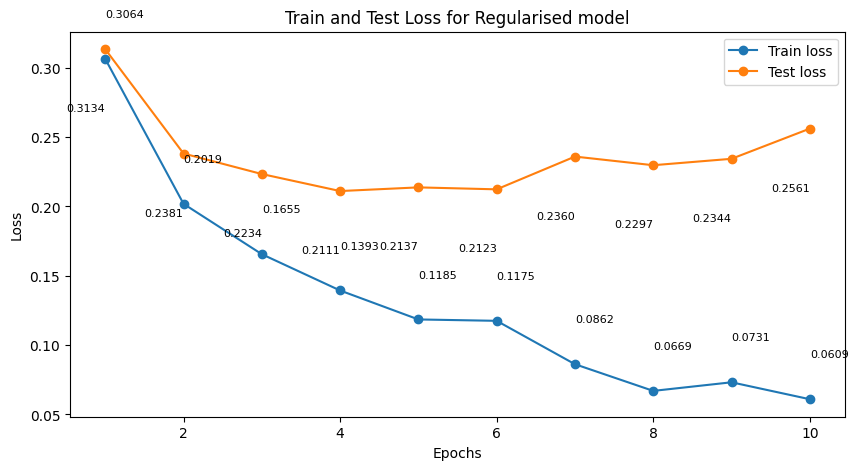

In [22]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

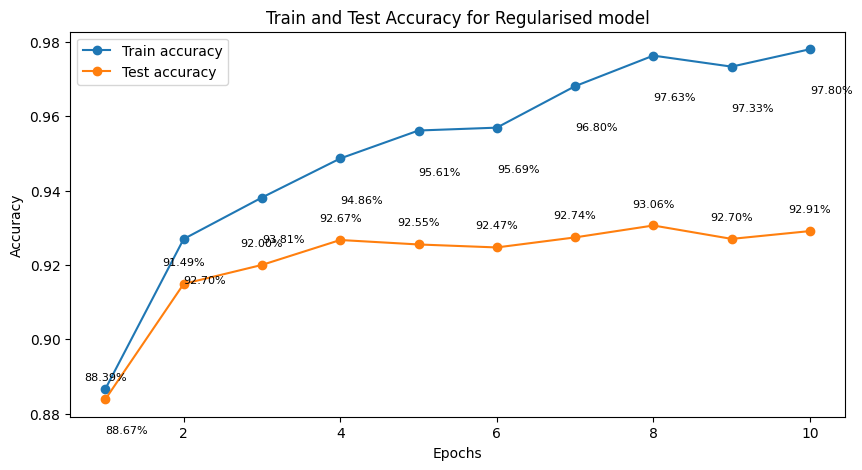

In [23]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [24]:
# Apply only regularisation on the cnn model
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion(useRegularization=True).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.304096  [   64/60000]
loss: 0.453861  [ 6464/60000]
loss: 0.376220  [12864/60000]
loss: 0.285291  [19264/60000]
loss: 0.262994  [25664/60000]
loss: 0.400555  [32064/60000]
loss: 0.322909  [38464/60000]
loss: 0.241589  [44864/60000]
loss: 0.393572  [51264/60000]
loss: 0.236618  [57664/60000]


Epochs:  10%|█         | 1/10 [00:29<04:23, 29.26s/it]

Train Error: 
 Accuracy: 91.5%, Avg loss: 0.242275 

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.273261 

Epoch 2:

loss: 0.275211  [   64/60000]
loss: 0.462128  [ 6464/60000]
loss: 0.281946  [12864/60000]
loss: 0.191373  [19264/60000]
loss: 0.200669  [25664/60000]
loss: 0.211779  [32064/60000]
loss: 0.259776  [38464/60000]
loss: 0.248922  [44864/60000]
loss: 0.442471  [51264/60000]
loss: 0.287450  [57664/60000]


Epochs:  20%|██        | 2/10 [00:59<04:00, 30.00s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.176158 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.222324 

Epoch 3:

loss: 0.122526  [   64/60000]
loss: 0.086429  [ 6464/60000]
loss: 0.142034  [12864/60000]
loss: 0.207220  [19264/60000]
loss: 0.329553  [25664/60000]
loss: 0.203415  [32064/60000]
loss: 0.242284  [38464/60000]
loss: 0.140351  [44864/60000]
loss: 0.081476  [51264/60000]
loss: 0.260094  [57664/60000]


Epochs:  30%|███       | 3/10 [01:29<03:28, 29.81s/it]

Train Error: 
 Accuracy: 94.8%, Avg loss: 0.149269 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.209971 

Epoch 4:

loss: 0.070646  [   64/60000]
loss: 0.159169  [ 6464/60000]
loss: 0.145335  [12864/60000]
loss: 0.161648  [19264/60000]
loss: 0.035428  [25664/60000]
loss: 0.261343  [32064/60000]
loss: 0.198495  [38464/60000]
loss: 0.236477  [44864/60000]
loss: 0.094553  [51264/60000]
loss: 0.058765  [57664/60000]


Epochs:  40%|████      | 4/10 [01:59<02:59, 29.93s/it]

Train Error: 
 Accuracy: 95.7%, Avg loss: 0.123398 

Test Error: 
 Accuracy: 92.7%, Avg loss: 0.207730 

Epoch 5:

loss: 0.143477  [   64/60000]
loss: 0.081150  [ 6464/60000]
loss: 0.142042  [12864/60000]
loss: 0.164678  [19264/60000]
loss: 0.169650  [25664/60000]
loss: 0.152742  [32064/60000]
loss: 0.105372  [38464/60000]
loss: 0.177820  [44864/60000]
loss: 0.147044  [51264/60000]
loss: 0.300674  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:28<02:28, 29.65s/it]

Train Error: 
 Accuracy: 95.9%, Avg loss: 0.112355 

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.222923 

Epoch 6:

loss: 0.244601  [   64/60000]
loss: 0.079749  [ 6464/60000]
loss: 0.033295  [12864/60000]
loss: 0.121366  [19264/60000]
loss: 0.045012  [25664/60000]
loss: 0.101835  [32064/60000]
loss: 0.086056  [38464/60000]
loss: 0.203462  [44864/60000]
loss: 0.026451  [51264/60000]
loss: 0.071265  [57664/60000]


Epochs:  60%|██████    | 6/10 [02:59<01:59, 29.90s/it]

Train Error: 
 Accuracy: 97.2%, Avg loss: 0.079222 

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.211678 

Epoch 7:

loss: 0.042747  [   64/60000]
loss: 0.090432  [ 6464/60000]
loss: 0.034839  [12864/60000]
loss: 0.099482  [19264/60000]
loss: 0.103890  [25664/60000]
loss: 0.174542  [32064/60000]
loss: 0.104242  [38464/60000]
loss: 0.223500  [44864/60000]
loss: 0.098898  [51264/60000]
loss: 0.032254  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:29<01:29, 29.94s/it]

Train Error: 
 Accuracy: 97.8%, Avg loss: 0.063971 

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.231865 

Epoch 8:

loss: 0.041098  [   64/60000]
loss: 0.090784  [ 6464/60000]
loss: 0.143296  [12864/60000]
loss: 0.093641  [19264/60000]
loss: 0.034387  [25664/60000]
loss: 0.012727  [32064/60000]
loss: 0.152633  [38464/60000]
loss: 0.144258  [44864/60000]
loss: 0.146757  [51264/60000]
loss: 0.038854  [57664/60000]


Epochs:  80%|████████  | 8/10 [03:59<01:00, 30.10s/it]

Train Error: 
 Accuracy: 97.8%, Avg loss: 0.058954 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.277438 

Epoch 9:

loss: 0.104547  [   64/60000]
loss: 0.025202  [ 6464/60000]
loss: 0.125064  [12864/60000]
loss: 0.030854  [19264/60000]
loss: 0.034746  [25664/60000]
loss: 0.121499  [32064/60000]
loss: 0.095584  [38464/60000]
loss: 0.132469  [44864/60000]
loss: 0.060478  [51264/60000]
loss: 0.037225  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:29<00:29, 29.97s/it]

Train Error: 
 Accuracy: 98.5%, Avg loss: 0.042107 

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.265869 

Epoch 10:

loss: 0.038320  [   64/60000]
loss: 0.011118  [ 6464/60000]
loss: 0.007125  [12864/60000]
loss: 0.018482  [19264/60000]
loss: 0.178708  [25664/60000]
loss: 0.023707  [32064/60000]
loss: 0.092161  [38464/60000]
loss: 0.173943  [44864/60000]
loss: 0.058436  [51264/60000]
loss: 0.068051  [57664/60000]


Epochs: 100%|██████████| 10/10 [04:59<00:00, 29.95s/it]

Train Error: 
 Accuracy: 99.1%, Avg loss: 0.026947 

Test Error: 
 Accuracy: 93.2%, Avg loss: 0.271064 

Done training!


Plotting metrics

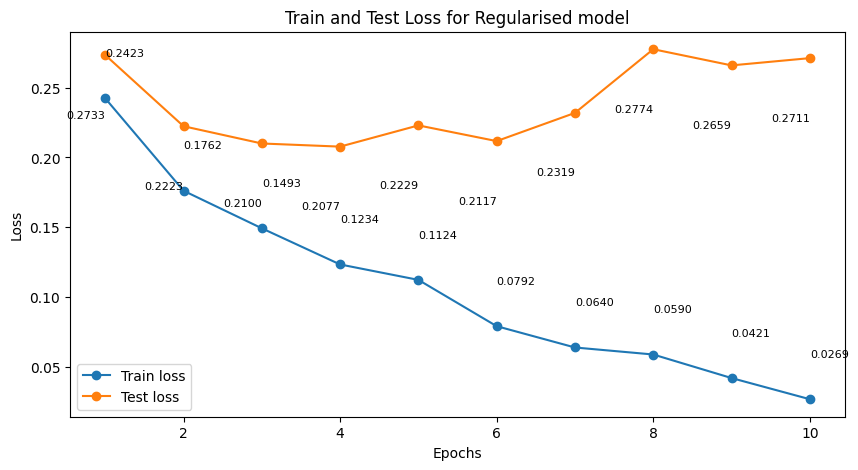

In [25]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

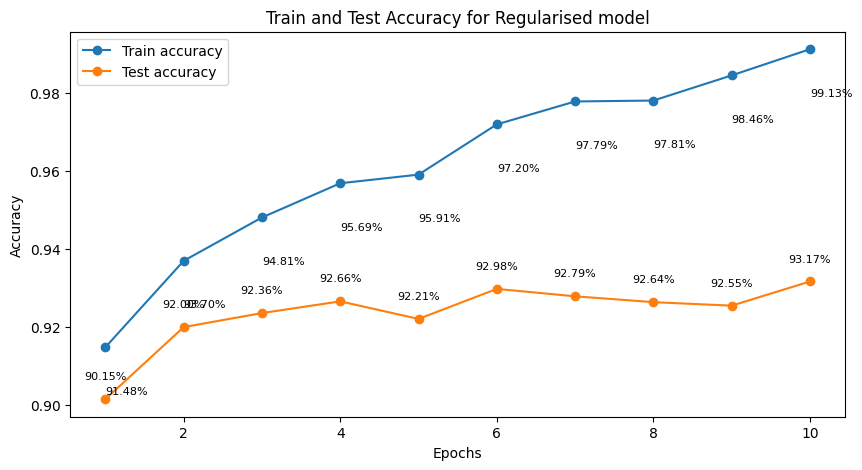

In [26]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

In [27]:
# Apply only weight decay technique
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=False)

model = NetFashion().to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.310840  [   64/60000]
loss: 0.235523  [ 6464/60000]
loss: 0.401285  [12864/60000]
loss: 0.363478  [19264/60000]
loss: 0.377392  [25664/60000]
loss: 0.271338  [32064/60000]
loss: 0.443921  [38464/60000]
loss: 0.479771  [44864/60000]
loss: 0.357670  [51264/60000]
loss: 0.296111  [57664/60000]


Epochs:  10%|█         | 1/10 [00:29<04:27, 29.72s/it]

Train Error: 
 Accuracy: 90.0%, Avg loss: 0.272651 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.305563 

Epoch 2:

loss: 0.322469  [   64/60000]
loss: 0.200575  [ 6464/60000]
loss: 0.394665  [12864/60000]
loss: 0.173667  [19264/60000]
loss: 0.253202  [25664/60000]
loss: 0.138385  [32064/60000]
loss: 0.238214  [38464/60000]
loss: 0.221158  [44864/60000]
loss: 0.336681  [51264/60000]
loss: 0.290962  [57664/60000]


Epochs:  20%|██        | 2/10 [01:00<04:00, 30.10s/it]

Train Error: 
 Accuracy: 92.6%, Avg loss: 0.206220 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.246140 

Epoch 3:

loss: 0.225173  [   64/60000]
loss: 0.286063  [ 6464/60000]
loss: 0.181229  [12864/60000]
loss: 0.264545  [19264/60000]
loss: 0.239499  [25664/60000]
loss: 0.247434  [32064/60000]
loss: 0.124484  [38464/60000]
loss: 0.228934  [44864/60000]
loss: 0.189226  [51264/60000]
loss: 0.227193  [57664/60000]


Epochs:  30%|███       | 3/10 [01:29<03:28, 29.77s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.173187 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.228863 

Epoch 4:

loss: 0.175177  [   64/60000]
loss: 0.133609  [ 6464/60000]
loss: 0.121053  [12864/60000]
loss: 0.110666  [19264/60000]
loss: 0.219129  [25664/60000]
loss: 0.195770  [32064/60000]
loss: 0.132325  [38464/60000]
loss: 0.279663  [44864/60000]
loss: 0.162661  [51264/60000]
loss: 0.279637  [57664/60000]


Epochs:  40%|████      | 4/10 [01:59<02:58, 29.83s/it]

Train Error: 
 Accuracy: 93.3%, Avg loss: 0.185832 

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.237289 

Epoch 5:

loss: 0.208104  [   64/60000]
loss: 0.144698  [ 6464/60000]
loss: 0.188844  [12864/60000]
loss: 0.194013  [19264/60000]
loss: 0.084150  [25664/60000]
loss: 0.112455  [32064/60000]
loss: 0.147695  [38464/60000]
loss: 0.189487  [44864/60000]
loss: 0.055390  [51264/60000]
loss: 0.159764  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:28<02:28, 29.63s/it]

Train Error: 
 Accuracy: 94.5%, Avg loss: 0.152769 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.217181 

Epoch 6:

loss: 0.152860  [   64/60000]
loss: 0.128464  [ 6464/60000]
loss: 0.280949  [12864/60000]
loss: 0.301182  [19264/60000]
loss: 0.321080  [25664/60000]
loss: 0.194635  [32064/60000]
loss: 0.272252  [38464/60000]
loss: 0.242787  [44864/60000]
loss: 0.117200  [51264/60000]
loss: 0.127234  [57664/60000]


Epochs:  60%|██████    | 6/10 [02:58<01:58, 29.61s/it]

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.134052 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.211880 

Epoch 7:

loss: 0.290608  [   64/60000]
loss: 0.242907  [ 6464/60000]
loss: 0.163875  [12864/60000]
loss: 0.067508  [19264/60000]
loss: 0.107168  [25664/60000]
loss: 0.178397  [32064/60000]
loss: 0.150114  [38464/60000]
loss: 0.073841  [44864/60000]
loss: 0.218808  [51264/60000]
loss: 0.097837  [57664/60000]


Epochs:  70%|███████   | 7/10 [03:27<01:28, 29.59s/it]

Train Error: 
 Accuracy: 95.2%, Avg loss: 0.132415 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.215026 

Epoch 8:

loss: 0.094694  [   64/60000]
loss: 0.153276  [ 6464/60000]
loss: 0.131661  [12864/60000]
loss: 0.100710  [19264/60000]
loss: 0.137271  [25664/60000]
loss: 0.113557  [32064/60000]
loss: 0.175891  [38464/60000]
loss: 0.130053  [44864/60000]
loss: 0.076584  [51264/60000]
loss: 0.140174  [57664/60000]


Epochs:  80%|████████  | 8/10 [03:57<00:58, 29.49s/it]

Train Error: 
 Accuracy: 96.0%, Avg loss: 0.118437 

Test Error: 
 Accuracy: 92.4%, Avg loss: 0.206976 

Epoch 9:

loss: 0.078720  [   64/60000]
loss: 0.011421  [ 6464/60000]
loss: 0.194716  [12864/60000]
loss: 0.079186  [19264/60000]
loss: 0.098494  [25664/60000]
loss: 0.074871  [32064/60000]
loss: 0.086992  [38464/60000]
loss: 0.278013  [44864/60000]
loss: 0.114045  [51264/60000]
loss: 0.104508  [57664/60000]


Epochs:  90%|█████████ | 9/10 [04:26<00:29, 29.57s/it]

Train Error: 
 Accuracy: 95.9%, Avg loss: 0.108420 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.216453 

Epoch 10:

loss: 0.186350  [   64/60000]
loss: 0.088530  [ 6464/60000]
loss: 0.165356  [12864/60000]
loss: 0.147841  [19264/60000]
loss: 0.192421  [25664/60000]
loss: 0.220488  [32064/60000]
loss: 0.149708  [38464/60000]
loss: 0.132184  [44864/60000]
loss: 0.039672  [51264/60000]
loss: 0.164003  [57664/60000]


Epochs: 100%|██████████| 10/10 [04:55<00:00, 29.60s/it]

Train Error: 
 Accuracy: 95.9%, Avg loss: 0.108985 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.228622 

Done training!


Plotting metrics

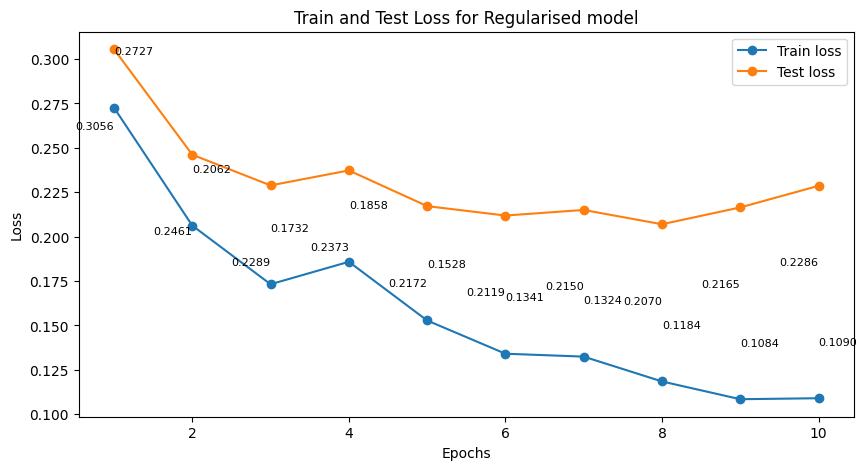

In [28]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

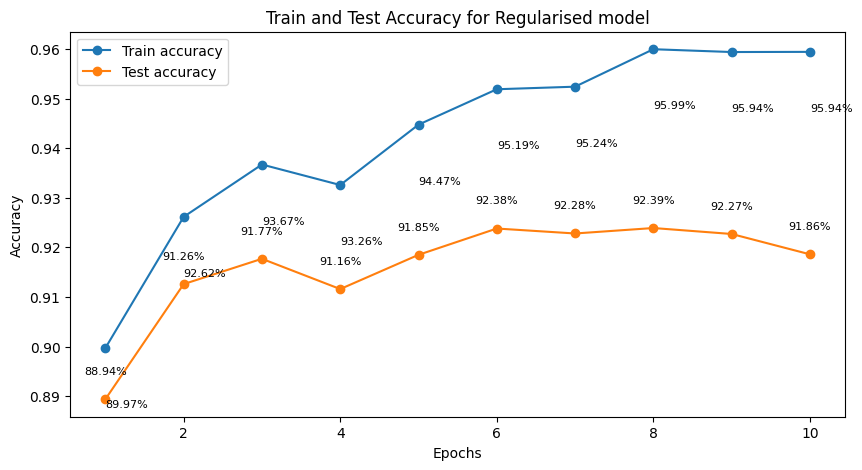

In [29]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

Apply all the regularisation techniques together below

In [30]:
# Apply all regularisation techniques
train_loader, test_loader = load_fashionMNIST_data(batch_size=64, augmentation=True)

model = NetFashion(useRegularization=True).to(device)
epochs = 10 # Increasing the number of epochs by 5 since the learning will be more gradual.
optimiser = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
train_loss, train_accuracy, test_loss, test_accuracy = train_loop(train_loader, test_loader, model, loss_fn, optimiser, epochs)

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:

loss: 2.301555  [   64/60000]
loss: 0.554002  [ 6464/60000]
loss: 0.361754  [12864/60000]
loss: 0.427194  [19264/60000]
loss: 0.545116  [25664/60000]
loss: 0.240555  [32064/60000]
loss: 0.288934  [38464/60000]
loss: 0.482949  [44864/60000]
loss: 0.342305  [51264/60000]
loss: 0.422027  [57664/60000]


Epochs:  10%|█         | 1/10 [00:34<05:10, 34.51s/it]

Train Error: 
 Accuracy: 90.2%, Avg loss: 0.267333 

Test Error: 
 Accuracy: 89.2%, Avg loss: 0.295147 

Epoch 2:

loss: 0.209132  [   64/60000]
loss: 0.283856  [ 6464/60000]
loss: 0.384282  [12864/60000]
loss: 0.132973  [19264/60000]
loss: 0.220998  [25664/60000]
loss: 0.202130  [32064/60000]
loss: 0.236781  [38464/60000]
loss: 0.239251  [44864/60000]
loss: 0.211928  [51264/60000]
loss: 0.223016  [57664/60000]


Epochs:  20%|██        | 2/10 [01:09<04:37, 34.63s/it]

Train Error: 
 Accuracy: 91.4%, Avg loss: 0.231011 

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.258124 

Epoch 3:

loss: 0.165440  [   64/60000]
loss: 0.214141  [ 6464/60000]
loss: 0.305584  [12864/60000]
loss: 0.176230  [19264/60000]
loss: 0.253120  [25664/60000]
loss: 0.258976  [32064/60000]
loss: 0.310173  [38464/60000]
loss: 0.320767  [44864/60000]
loss: 0.232735  [51264/60000]
loss: 0.256179  [57664/60000]


Epochs:  30%|███       | 3/10 [01:43<04:02, 34.59s/it]

Train Error: 
 Accuracy: 92.7%, Avg loss: 0.198765 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.237201 

Epoch 4:

loss: 0.246516  [   64/60000]
loss: 0.299951  [ 6464/60000]
loss: 0.316418  [12864/60000]
loss: 0.166734  [19264/60000]
loss: 0.148688  [25664/60000]
loss: 0.334025  [32064/60000]
loss: 0.188097  [38464/60000]
loss: 0.318722  [44864/60000]
loss: 0.147441  [51264/60000]
loss: 0.250453  [57664/60000]


Epochs:  40%|████      | 4/10 [02:18<03:27, 34.54s/it]

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.190107 

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.230701 

Epoch 5:

loss: 0.362328  [   64/60000]
loss: 0.127246  [ 6464/60000]
loss: 0.395254  [12864/60000]
loss: 0.262818  [19264/60000]
loss: 0.156816  [25664/60000]
loss: 0.179834  [32064/60000]
loss: 0.107043  [38464/60000]
loss: 0.237075  [44864/60000]
loss: 0.281409  [51264/60000]
loss: 0.101522  [57664/60000]


Epochs:  50%|█████     | 5/10 [02:52<02:52, 34.54s/it]

Train Error: 
 Accuracy: 92.5%, Avg loss: 0.203319 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.249663 

Epoch 6:

loss: 0.095604  [   64/60000]
loss: 0.229548  [ 6464/60000]
loss: 0.212241  [12864/60000]
loss: 0.406431  [19264/60000]
loss: 0.254277  [25664/60000]
loss: 0.047355  [32064/60000]
loss: 0.166585  [38464/60000]
loss: 0.257349  [44864/60000]
loss: 0.167505  [51264/60000]
loss: 0.249577  [57664/60000]


Epochs:  60%|██████    | 6/10 [03:27<02:18, 34.53s/it]

Train Error: 
 Accuracy: 93.5%, Avg loss: 0.183897 

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.224254 

Epoch 7:

loss: 0.200486  [   64/60000]
loss: 0.106232  [ 6464/60000]
loss: 0.286640  [12864/60000]
loss: 0.353256  [19264/60000]
loss: 0.190386  [25664/60000]
loss: 0.167563  [32064/60000]
loss: 0.263085  [38464/60000]
loss: 0.389345  [44864/60000]
loss: 0.160843  [51264/60000]
loss: 0.255318  [57664/60000]


Epochs:  70%|███████   | 7/10 [04:01<01:43, 34.52s/it]

Train Error: 
 Accuracy: 94.0%, Avg loss: 0.164700 

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.212225 

Epoch 8:

loss: 0.177397  [   64/60000]
loss: 0.140938  [ 6464/60000]
loss: 0.168801  [12864/60000]
loss: 0.293875  [19264/60000]
loss: 0.203610  [25664/60000]
loss: 0.078944  [32064/60000]
loss: 0.269634  [38464/60000]
loss: 0.156654  [44864/60000]
loss: 0.107045  [51264/60000]
loss: 0.211208  [57664/60000]


Epochs:  80%|████████  | 8/10 [04:35<01:08, 34.37s/it]

Train Error: 
 Accuracy: 93.6%, Avg loss: 0.171334 

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.222423 

Epoch 9:

loss: 0.241649  [   64/60000]
loss: 0.106611  [ 6464/60000]
loss: 0.097153  [12864/60000]
loss: 0.207637  [19264/60000]
loss: 0.184812  [25664/60000]
loss: 0.249514  [32064/60000]
loss: 0.277808  [38464/60000]
loss: 0.216550  [44864/60000]
loss: 0.217772  [51264/60000]
loss: 0.100245  [57664/60000]


Epochs:  90%|█████████ | 9/10 [05:10<00:34, 34.44s/it]

Train Error: 
 Accuracy: 93.7%, Avg loss: 0.169744 

Test Error: 
 Accuracy: 91.3%, Avg loss: 0.227994 

Epoch 10:

loss: 0.162212  [   64/60000]
loss: 0.127255  [ 6464/60000]
loss: 0.284782  [12864/60000]
loss: 0.191335  [19264/60000]
loss: 0.173120  [25664/60000]
loss: 0.225097  [32064/60000]
loss: 0.159857  [38464/60000]
loss: 0.086961  [44864/60000]
loss: 0.111590  [51264/60000]
loss: 0.224336  [57664/60000]


Epochs: 100%|██████████| 10/10 [05:45<00:00, 34.51s/it]

Train Error: 
 Accuracy: 94.2%, Avg loss: 0.158884 

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.213805 

Done training!


Plotting metrics

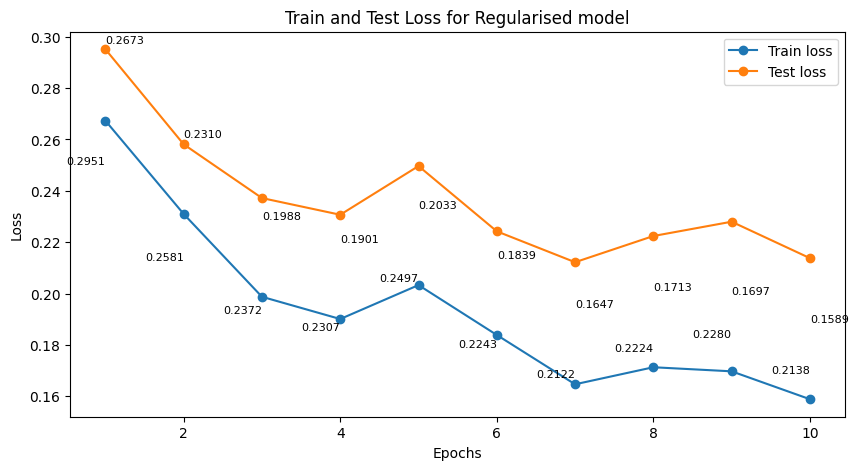

In [31]:
epochRange = range(1, epochs+1)
# Defining data and plot params
lossDataList = [(train_loss, {'label': 'Train loss', 'decimalPlaces': 4, 'displayOffset': 0.03, 'ha': 'left'}),
                (test_loss, {'label': 'Test loss', 'decimalPlaces': 4, 'displayOffset': -0.045, 'ha': 'right'})]
plotTitle = 'Train and Test Loss for Regularised model'

# Calling my custom util function to plot loss data
plotMetrics(lossDataList, epochRange, xlabel='Epochs', ylabel='Loss', title=plotTitle, legend=True, figSize=(10, 5))

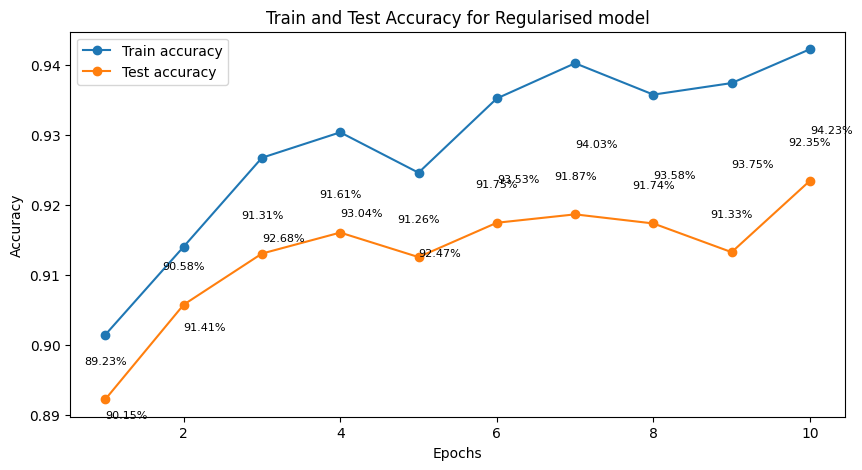

In [32]:
# Defining data and plot params
accuracyDataList = [(train_accuracy, {'label': 'Train accuracy', 'displayOffset': -0.012,
                                      'decimalPlaces': 2, 'displayPercent': True, 'ha': 'left'}),
                (test_accuracy, {'label': 'Test accuracy', 'displayOffset': 0.005,
                                 'decimalPlaces': 2, 'displayPercent': True})]
plotTitle = 'Train and Test Accuracy for Regularised model'

# Calling my custom util function to plot accuracy data
plotMetrics(accuracyDataList, epochRange, xlabel='Epochs', ylabel='Accuracy', title=plotTitle, legend=True, figSize=(10, 5))

## Reflection <font color='green'>(1 point)</font>
Write your thoughts and observations about overfitting and the techniques used above to reduce them in brief.

<font color='red'>Overfitting occurs when a model learns patterns that are too specific to the training data, leading to poor generalization on unseen data. It basically memorizes the training data. The techniques that we applied help to reduce overfitting were Data Augementation, Dropouts, Weight Decay. Data Augmentation helps to introduce variations in the training data.Dropout prevented over-reliance on specific neurons by randomly deactivating a portion of them during training, forcing the network to learn more general features.Weight decay works by adding a penalty to large weight values, encouraging the model to maintain simpler, more generalized representations. All these techniques prevent the model from memorizing specific details of the training set and instead help it focus on meaningful patterns. </font>

